# E7 - Decision Trees - Bagging

Elaborado por GRUPO 1:

- Juanita Piraban Barbosa - 201216313
- Lorena Morales Rodríguez - 202027957
- Alejandro Barinas Guio - 201628859
- Jaime Humberto Trujillo Perea - 201920366
- Alexander Zapata Galindo - 201425426

In [35]:
# Librerías
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from sklearn.tree import DecisionTreeClassifier 
from sklearn.model_selection import train_test_split 
from sklearn import metrics 
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import BaggingClassifier

from sklearn.metrics import mean_squared_error

from tabulate import tabulate

import statsmodels.api as sm
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

# Parte 1 - Capital Bikeshare data

## Introduction

- Capital Bikeshare dataset from Kaggle: [data](https://github.com/justmarkham/DAT8/blob/master/data/bikeshare.csv), [data dictionary](https://www.kaggle.com/c/bike-sharing-demand/data)
- Each observation represents the bikeshare rentals initiated during a given hour of a given day

In [36]:
# read the data and set "datetime" as the index
bikes = pd.read_csv('Dataset/bikeshare.csv', index_col='datetime', parse_dates=True)

# "count" is a method, so it's best to rename that column
bikes.rename(columns={'count':'total'}, inplace=True)

# create "hour" as its own feature
bikes['hour'] = bikes.index.hour
bikes.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,total,hour
datetime,,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,0
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,1
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,3
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,4


In [37]:
bikes.tail()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,total,hour
datetime,,,,,,,,,,,,
2012-12-19 19:00:00,4,0,1,1,15.58,19.695,50,26.0027,7,329,336,19
2012-12-19 20:00:00,4,0,1,1,14.76,17.425,57,15.0013,10,231,241,20
2012-12-19 21:00:00,4,0,1,1,13.94,15.910,61,15.0013,4,164,168,21
2012-12-19 22:00:00,4,0,1,1,13.94,17.425,61,6.0032,12,117,129,22
2012-12-19 23:00:00,4,0,1,1,13.12,16.665,66,8.9981,4,84,88,23


- **hour** ranges from 0 (midnight) through 23 (11pm)
- **workingday** is either 0 (weekend or holiday) or 1 (non-holiday weekday)

# Exercise 7.1

Run these two `groupby` statements and figure out what they tell you about the data.

In [38]:
# mean rentals for each value of "workingday"
bikes.groupby('workingday').total.mean()

workingday
0    188.506621
1    193.011873
Name: total, dtype: float64

In [39]:
# mean rentals for each value of "hour"
bikes.groupby('hour').total.mean()

hour
0      55.138462
1      33.859031
2      22.899554
3      11.757506
4       6.407240
5      19.767699
6      76.259341
7     213.116484
8     362.769231
9     221.780220
10    175.092308
11    210.674725
12    256.508772
13    257.787281
14    243.442982
15    254.298246
16    316.372807
17    468.765351
18    430.859649
19    315.278509
20    228.517544
21    173.370614
22    133.576754
23     89.508772
Name: total, dtype: float64

# Exercise 7.2

Run this plotting code, and make sure you understand the output. Then, separate this plot into two separate plots conditioned on "workingday". (In other words, one plot should display the hourly trend for "workingday=0", and the other should display the hourly trend for "workingday=1".)

<AxesSubplot:xlabel='hour'>

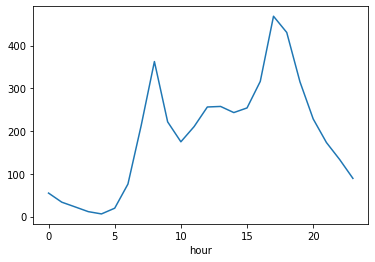

In [40]:
# mean rentals for each value of "hour"
bikes.groupby('hour').total.mean().plot()

Plot for workingday == 0 and workingday == 1

<AxesSubplot:xlabel='hour'>

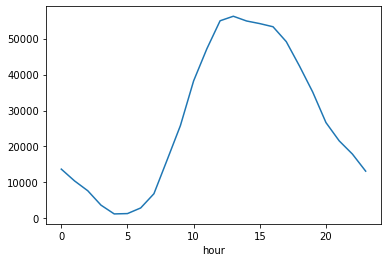

In [41]:
# hourly rental trend for "workingday=0"
f_semana=bikes[(bikes['workingday'] == 0)]
f_semana.groupby('hour').total.sum().plot()

<AxesSubplot:xlabel='hour'>

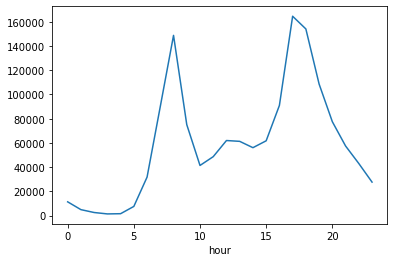

In [42]:
# hourly rental trend for "workingday=1"
e_semana=bikes[(bikes['workingday'] == 1)]
e_semana.groupby('hour').total.sum().plot()

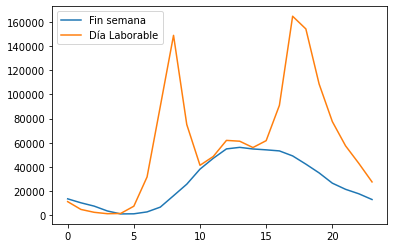

In [43]:
# combine the two plots
plt.plot (f_semana.groupby('hour').total.sum())+ plt.plot (e_semana.groupby('hour').total.sum())
plt.gca().legend(('Fin semana','Día Laborable'))
plt.show()

COMENTARIOS: Del gráfico combinado se destaca:
 
1- El uso de bicicletas compartidas presenta un comportamiento similar en los fines de semana al de los dias laborales, entre las 12:00 pm a 3:00 pm. 

2- En los dìas laborales los mayores picos de uso de bicicletas se encuentran en horas de la mañana y la tarde que conciden con los horarios laborales de ingreso y salida (8:00 am y 18:00 pm) en segundo y pico aunque menos pronunciado sobre el medio dìa (12:00 pm).

# Exercise 7.3

Fit a linear regression model to the entire dataset, using "total" as the response and "hour" and "workingday" as the only features. Then, print the coefficients and interpret them. What are the limitations of linear regression in this instance?

1- Revisamos el Dataframe revisando que no presente valores nulos, asi evitar problemas en la aplicación de los algoritmos.

In [44]:
print(bikes.isnull().sum(axis= 0))

season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
total         0
hour          0
dtype: int64


2- Damos un vistazo a la distribucción de la variable a explicar a fin de identificar posibles inconsistencias

<AxesSubplot:ylabel='Frequency'>

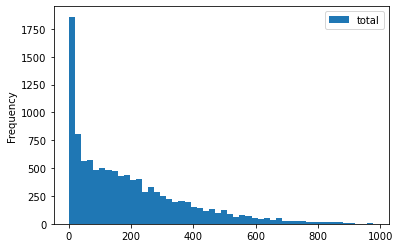

In [45]:
df = pd.DataFrame(bikes.loc[:, ['total', 'hour', 'workingday']])
df['total'].plot(kind = 'hist', bins=50, legend = True)

<AxesSubplot:ylabel='Frequency'>

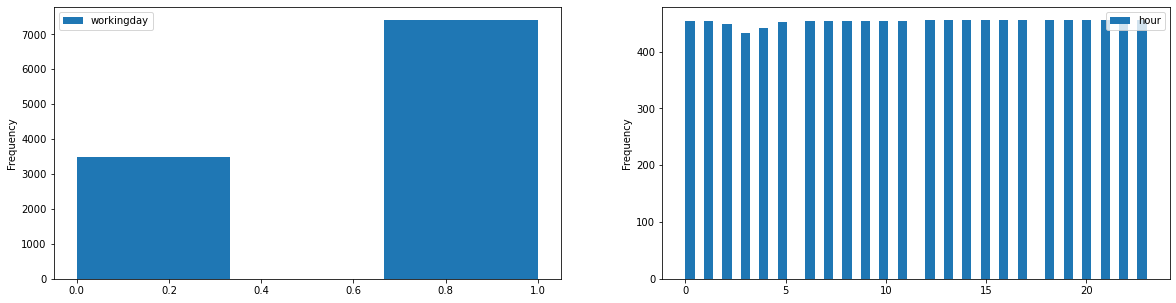

In [46]:
fig,ax = plt.subplots(1, 2)
fig.set_size_inches(20,5)
df['workingday'].plot(kind = 'hist',bins = 3, legend = True, ax =ax[0])
df['hour'].plot(kind = 'hist',bins = 50, legend = True, ax =ax[1])

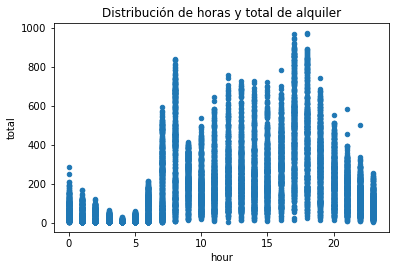

In [47]:
fig, ax = plt.subplots(figsize=(6, 3.84))

df.plot(
    x    = 'hour',
    y    = 'total',     
    kind = "scatter",
    ax   = ax)
ax.set_title('Distribución de horas y total de alquiler');

In [48]:
# División de los datos en train y test y ajuste de parametros para la regresión
# ==============================================================================
X = df[['hour', 'workingday']]
y = df['total']

X_train, X_test, y_train, y_test = train_test_split(
                                        X,
                                        y.values.reshape(-1,1),
                                        train_size   = 0.8,
                                        random_state = 1234,
                                        shuffle      = True
                                    )

In [49]:
# Modelo
X_train = sm.add_constant(X_train, prepend=True)
modelo = sm.OLS(endog=y_train, exog=X_train,)
modelo = modelo.fit()
print(modelo.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.157
Model:                            OLS   Adj. R-squared:                  0.157
Method:                 Least Squares   F-statistic:                     811.2
Date:                Tue, 20 Jul 2021   Prob (F-statistic):          9.88e-324
Time:                        22:00:41   Log-Likelihood:                -56905.
No. Observations:                8708   AIC:                         1.138e+05
Df Residuals:                    8705   BIC:                         1.138e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         67.2782      4.305     15.627      0.0

In [50]:
# Prediccion del modelo con muestra de entrenamiento
prediccion_train = modelo.predict(exog = X_train)

In [51]:
# Diagnóstico errores (residuos) de las predicciones de entrenamiento
# ==============================================================================
y_train = y_train.flatten()
prediccion_train = modelo.predict(exog = X_train)
residuos_train   = prediccion_train - y_train

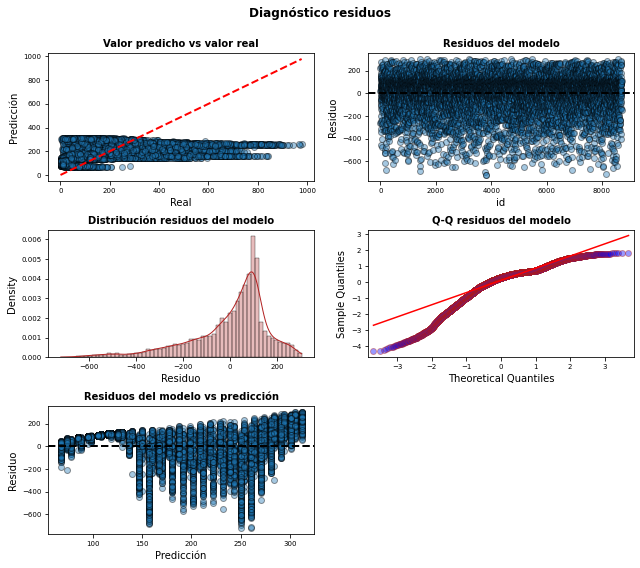

In [52]:
#Gráficos
# ==============================================================================
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(9, 8))

axes[0, 0].scatter(y_train, prediccion_train, edgecolors=(0, 0, 0), alpha = 0.4)
axes[0, 0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()],
                'k--', color = 'Red', lw=2)
axes[0, 0].set_title('Valor predicho vs valor real', fontsize = 10, fontweight = "bold")
axes[0, 0].set_xlabel('Real')
axes[0, 0].set_ylabel('Predicción')
axes[0, 0].tick_params(labelsize = 7)

axes[0, 1].scatter(list(range(len(y_train))), residuos_train,
                   edgecolors=(0, 0, 0), alpha = 0.4)
axes[0, 1].axhline(y = 0, linestyle = '--', color = 'black', lw=2)
axes[0, 1].set_title('Residuos del modelo', fontsize = 10, fontweight = "bold")
axes[0, 1].set_xlabel('id')
axes[0, 1].set_ylabel('Residuo')
axes[0, 1].tick_params(labelsize = 7)

sns.histplot(
    data    = residuos_train,
    stat    = "density",
    kde     = True,
    line_kws= {'linewidth': 1},
    color   = "firebrick",
    alpha   = 0.3,
    ax      = axes[1, 0]
)

axes[1, 0].set_title('Distribución residuos del modelo', fontsize = 10,
                     fontweight = "bold")
axes[1, 0].set_xlabel("Residuo")
axes[1, 0].tick_params(labelsize = 7)


sm.qqplot(
    residuos_train,
    fit   = True,
    line  = 'q',
    ax    = axes[1, 1], 
    color = 'firebrick',
    alpha = 0.4,
    lw    = 2
)
axes[1, 1].set_title('Q-Q residuos del modelo', fontsize = 10, fontweight = "bold")
axes[1, 1].tick_params(labelsize = 7)

axes[2, 0].scatter(prediccion_train, residuos_train,
                   edgecolors=(0, 0, 0), alpha = 0.4)
axes[2, 0].axhline(y = 0, linestyle = '--', color = 'black', lw=2)
axes[2, 0].set_title('Residuos del modelo vs predicción', fontsize = 10, fontweight = "bold")
axes[2, 0].set_xlabel('Predicción')
axes[2, 0].set_ylabel('Residuo')
axes[2, 0].tick_params(labelsize = 7)

# Se eliminan los axes vacíos
fig.delaxes(axes[2,1])

fig.tight_layout()
plt.subplots_adjust(top=0.9)
fig.suptitle('Diagnóstico residuos', fontsize = 12, fontweight = "bold");

In [53]:
# Error de test del modelo
# ==============================================================================
X_test = sm.add_constant(X_test, prepend=True)
predicciones = modelo.predict(exog = X_test)
rmse_reg = mean_squared_error(
        y_true  = y_test,
        y_pred  = predicciones,
        squared = False
       )
print("")
print(f"El rmse de la regresión es: {rmse_reg})")


El rmse de la regresión es: 163.2399717241645)


### Evaluacion Modelo: 
- El modelo de regresión lineal utilizando las variables (Hora, workingday) como predictores, alcanza un R2 muy bajo (.157), la regresión lineal es capaz de explicar tan solo el 15,7% de la variabilidad observada en la variable (Total).
- Modelo estimado: Total = 67.2782 + 10.3292(Hour) + 7.0503(Workingday)
- Evaluando el p-value obtenido para el coeficiente parcial de regresión de Workingday (0.066), esta variable no contribuye de forma significativa en el modelo.
- Al interpretar los coeficientes encontramos que la utlización aumenta 7 unidades en días laborables y aumenta 10 unidades por cada hora transcurrida entre las 0:00 horas y las 11:00 pm.

# Exercice 7.4

Create a Decision Tree to forecast "total" by manually iterating over the features "hour" and "workingday". The algorithm must at least have 6 end nodes.

In [54]:
class DecisionTreeRegressorCustom:
  
  def fit(self, X, y, min_leaf = 6):
    self.dtree = Node(X, y, np.array(np.arange(len(y))), min_leaf)
    return self
  
  def predict(self, X):
    return self.dtree.predict(X.values)

In [55]:
class Node:

    def __init__(self, x, y, idxs, min_leaf=5):
        self.x = x 
        self.y = y
        self.idxs = idxs 
        self.min_leaf = min_leaf
        self.row_count = len(idxs)
        self.col_count = x.shape[1]
        self.val = np.mean(y[idxs])
        self.score = float('inf')
        self.find_varsplit()
        
    def find_varsplit(self):
        for c in range(self.col_count): self.find_better_split(c)
        if self.is_leaf: return
        x = self.split_col
        lhs = np.nonzero(x <= self.split)[0]
        rhs = np.nonzero(x > self.split)[0]
        self.lhs = Node(self.x, self.y, self.idxs[lhs], self.min_leaf)
        self.rhs = Node(self.x, self.y, self.idxs[rhs], self.min_leaf)
        
    def find_better_split(self, var_idx):
      
        x = self.x.values[self.idxs, var_idx]

        for r in range(self.row_count):
            lhs = x <= x[r]
            rhs = x > x[r]
            if rhs.sum() < self.min_leaf or lhs.sum() < self.min_leaf: continue

            curr_score = self.find_score(lhs, rhs)
            if curr_score < self.score: 
                self.var_idx = var_idx
                self.score = curr_score
                self.split = x[r]
                
    def find_score(self, lhs, rhs):
        y = self.y[self.idxs]
        lhs_std = y[lhs].std()
        rhs_std = y[rhs].std()
        return lhs_std * lhs.sum() + rhs_std * rhs.sum()
                
    @property
    def split_col(self): return self.x.values[self.idxs,self.var_idx]
                
    @property
    def is_leaf(self): return self.score == float('inf')                

    def predict(self, x):
        return np.array([self.predict_row(xi) for xi in x])

    def predict_row(self, xi):
        if self.is_leaf: return self.val
        node = self.lhs if xi[self.var_idx] <= self.split else self.rhs
        return node.predict_row(xi)

In [56]:
regressor = DecisionTreeRegressorCustom().fit(X_train, y_test)

In [57]:
y_pred = regressor.predict(X_test)

In [58]:
rmse_tree_manual = np.sqrt(mean_squared_error(y_pred, y_test))
print("")
print(f"El rmse del Arbol construido de forma manual es: {rmse_tree_manual}")


El rmse del Arbol construido de forma manual es: 182.8411204644076


NOTA: El desarrollo de este punto se soporto en la siguiente referencia: https://levelup.gitconnected.com/building-a-decision-tree-from-scratch-in-python-machine-learning-from-scratch-part-ii-6e2e56265b19

# Exercise 7.5

Train a Decision Tree using scikit-learn. Comment about the performance of the models.

In [59]:
X = df[['hour', 'workingday']]
y = df['total']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20,
                                                    random_state=123,
                                                    shuffle=True)

Text(0.5, 1.0, 'Ajuste del arbol con Tuning')

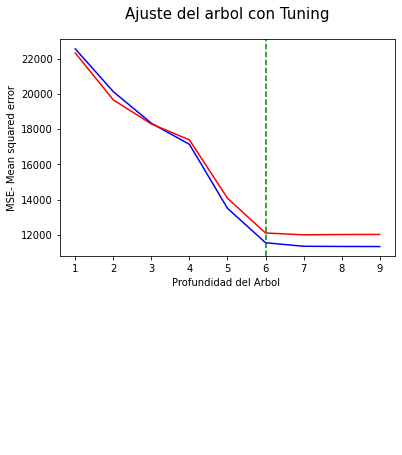

In [60]:
from sklearn.metrics import mean_squared_error as mse

max_depths = range(1, 10) 

training_error = []
for max_depth in max_depths:
    model_1 = DecisionTreeRegressor(max_depth=max_depth)
    model_1.fit(X, y)
    training_error.append(mse(y, model_1.predict(X)))
    
testing_error = []
for max_depth in max_depths:
    model_2 = DecisionTreeRegressor(max_depth=max_depth)
    model_2.fit(X_train, y_train)
    testing_error.append(mse(y_test, model_2.predict(X_test)))

plt.plot(max_depths, training_error, color='blue', label='Error en Training')
plt.plot(max_depths, testing_error, color='red', label='Error en Testing')
plt.xlabel('Profundidad del Arbol ')
plt.axvline(x=6, color='green', linestyle='--')
plt.annotate('optimum = 10', xy=(5, 1.17), color='red')
plt.ylabel('MSE- Mean squared error')
plt.title('Ajuste del arbol con Tuning', pad=20, size=15)

In [61]:
# Prediccion del modelo
model_1.fit(X_train, y_train)
y_pred = model_1.predict (X_test)

In [62]:
# Error
mse = mean_squared_error(y_test, y_pred)
rmse_Tree = np.sqrt(mse)
print("")
print(f"El rmse del Arbol con sklearn.tree es: {rmse_Tree}")


El rmse del Arbol con sklearn.tree es: 109.62941339498562


### Evaluacion Modelo

- En punto optimo de profundidad del Arbol es 6, al observar los valores que toma el MSE en la muestra de entrenamiento en este punto se mantiene estable sin cambios, entre tanto en Testing el error mejora manteniendo si caida en este punto.
- El arbol de decisión evaluado en su MSE mejora su error respecto a la regresión y el arbol construido de forma manual, llegando a 109.62.

### Evaluacion finales del Modelo

- El mse de la regresión es: 163.23
- El mse del Arbol construido de forma manual es: 182.84
- El mse del Arbol por sklearn.tree es: 109.62

### Al evaluar los resultados el modelo con mejor desempeño es el Arbol por sklearn.tree


# Parte 2 - Bagging

## Mashable news stories analysis

Predicting if a news story is going to be popular

In [63]:
df = pd.read_csv('Dataset/mashable.csv', index_col=0)
df.head()

,url,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,Popular
0,http://mashable.com/2014/12/10/cia-torture-rep...,28.0,9.0,188.0,0.732620,1.0,0.844262,5.0,1.0,1.0,...,0.200000,0.80,-0.487500,-0.60,-0.250000,0.9,0.8,0.4,0.8,1
1,http://mashable.com/2013/10/18/bitlock-kicksta...,447.0,7.0,297.0,0.653199,1.0,0.815789,9.0,4.0,1.0,...,0.160000,0.50,-0.135340,-0.40,-0.050000,0.1,-0.1,0.4,0.1,0
2,http://mashable.com/2013/07/24/google-glass-po...,533.0,11.0,181.0,0.660377,1.0,0.775701,4.0,3.0,1.0,...,0.136364,1.00,0.000000,0.00,0.000000,0.3,1.0,0.2,1.0,0
3,http://mashable.com/2013/11/21/these-are-the-m...,413.0,12.0,781.0,0.497409,1.0,0.677350,10.0,3.0,1.0,...,0.100000,1.00,-0.195701,-0.40,-0.071429,0.0,0.0,0.5,0.0,0
4,http://mashable.com/2014/02/11/parking-ticket-...,331.0,8.0,177.0,0.685714,1.0,0.830357,3.0,2.0,1.0,...,0.100000,0.55,-0.175000,-0.25,-0.100000,0.0,0.0,0.5,0.0,0


In [64]:
X = df.drop(['url', 'Popular'], axis=1)
y = df['Popular']

In [65]:
y.describe()

count    6000.000000
mean        0.500000
std         0.500042
min         0.000000
25%         0.000000
50%         0.500000
75%         1.000000
max         1.000000
Name: Popular, dtype: float64

In [66]:
y.value_counts().to_frame('count').assign(percentage = lambda x: x/x.sum())

,count,percentage
1,3000,0.5
0,3000,0.5


In [67]:
X.describe()

,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,...,avg_positive_polarity,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity
count,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,...,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000
mean,358.138833,10.368667,547.428833,0.527732,0.961333,0.665823,11.874000,3.272500,4.954667,1.463167,...,0.357497,0.097194,0.762009,-0.265334,-0.530531,-0.110047,0.296854,0.077178,0.343496,0.167633
std,210.734614,2.106140,510.232776,0.148356,0.192815,0.167740,13.444103,4.262895,8.635916,4.508144,...,0.112586,0.076585,0.256845,0.133800,0.294477,0.100482,0.334117,0.282790,0.186815,0.240462
min,9.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,-1.000000,-1.000000,-1.000000,0.000000,-1.000000,0.000000,0.000000
25%,175.000000,9.000000,231.000000,0.465950,1.000000,0.619624,4.000000,1.000000,1.000000,0.000000,...,0.308693,0.050000,0.600000,-0.340000,-0.714286,-0.125000,0.000000,0.000000,0.166667,0.000000
50%,345.000000,10.000000,391.000000,0.541477,1.000000,0.689119,8.000000,2.000000,1.000000,0.000000,...,0.364237,0.100000,0.800000,-0.260185,-0.500000,-0.100000,0.200000,0.000000,0.500000,0.016667
75%,544.250000,12.000000,719.000000,0.614980,1.000000,0.756237,15.000000,4.000000,7.000000,1.000000,...,0.419669,0.100000,1.000000,-0.191273,-0.300000,-0.050000,0.500000,0.166667,0.500000,0.250000
max,731.000000,19.000000,8474.000000,0.967742,1.000000,1.000000,304.000000,116.000000,111.000000,91.000000,...,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.500000,1.000000


In [68]:
# train/test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123)

# Train vs test
table = [[y_train.describe(), y_test.describe()]]
headers = ['Train', 'Test']
print(tabulate(table,headers))

Train                          Test
-----------------------------  -----------------------------
count    4500.000000           count    1500.000000
mean        0.502444           mean        0.492667
std         0.500050           std         0.500113
min         0.000000           min         0.000000
25%         0.000000           25%         0.000000
50%         1.000000           50%         0.000000
75%         1.000000           75%         1.000000
max         1.000000           max         1.000000
Name: Popular, dtype: float64  Name: Popular, dtype: float64


In [69]:
y_train.value_counts().to_frame('count').assign(percentage = lambda x: x/x.sum())

,count,percentage
1,2261,0.502444
0,2239,0.497556


In [70]:
y_test.value_counts().to_frame('count').assign(percentage = lambda x: x/x.sum())

,count,percentage
0,761,0.507333
1,739,0.492667


# Exercise 7.6

Estimate a Decision Tree Classifier and a Logistic Regression

Evaluate using the following metrics:
* Accuracy
* F1-Score

### i) Árbol de Decisión

In [ ]:
# list of values to try for max_depth
max_depth_range = range(1, 31)

# list to store the average RMSE for each value of max_depth
accuracy_scores = []

# use 10-fold cross-validation with each value of max_depth
for depth in max_depth_range:
    clf = DecisionTreeClassifier(max_depth=depth, random_state=1)
    accuracy_scores.append(cross_val_score(clf, X_train, y_train, cv=10, scoring='accuracy').mean())

In [ ]:
# plot max_depth (x-axis) versus Accuracy (y-axis)
plt.plot(max_depth_range, accuracy_scores)
plt.xlabel('max_depth')
plt.ylabel('Accuracy')

In [ ]:
# show the best accuracy and the corresponding max_depth
tunning=sorted(zip(accuracy_scores, max_depth_range))[::-1][0]
print("Best accuracy",tunning[0])
print("Max Depth",tunning[1])

In [ ]:
# once best max_depth is selected, so fit a tree using that parameter
clf = DecisionTreeClassifier(max_depth=tunning[1], random_state=123)
accuracy_scores.append(cross_val_score(clf, X_train, y_train, cv=10, scoring='accuracy').mean())
clf.fit(X_train, y_train)

In [ ]:
# compute feature importances (top 10)
feature_cols = X.columns[X.columns.str.startswith('C') == False]

pd.DataFrame({'feature':feature_cols, 'importance':clf.feature_importances_}).sort_values('importance',ascending=False).head(10)

In [ ]:
# predict 
y_pred = clf.predict(X_test)
y_pred=pd.DataFrame(y_pred)

# real vs predict
table = [[y_test.describe(), y_pred.describe()[-0]]]
headers = ['Real', 'Predict']
print(tabulate(table,headers))

In [ ]:
# confusion matrix
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

In [ ]:
# metrics
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("F1 score:",metrics.f1_score(y_test, y_pred))

print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))

### ii) Regresión Logistica

In [ ]:
# model
logreg = LogisticRegression()

# fit and predict
logreg.fit(X_train,y_train)
y_pred = logreg.predict(X_test)
y_pred=pd.DataFrame(y_pred)

In [ ]:
# real vs predict
table = [[y_test.describe(), y_pred.describe()[-0]]]
headers = ['Real', 'Predict']
print(tabulate(table,headers))

In [ ]:
# confusion matrix
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

In [ ]:
# metrics
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("F1 score:",metrics.f1_score(y_test, y_pred))

print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))

# Exercise 7.7

i) Estimate 300 bagged samples

### 300 bagged samples

In [ ]:
# set a seed for reproducibility
seed = np.random.seed(123)
n_samples = X_train.shape[0]
n_B = 300

# create bootstrap samples (will be used to select rows from the DataFrame)
samples = [np.random.choice(a=n_samples, size=n_samples, replace=True) for _ in range(1, n_B +1 )]

# grow each tree deep
#bagclf = BaggingClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=n_B, bootstrap=True,
#                        random_state=seed, n_jobs=-1, oob_score=True)

bagclf = DecisionTreeClassifier()

# DataFrame for storing predicted from each tree
y_pred_all = []

# grow one tree for each bootstrap sample and make predictions on testing data
for i in range(n_B):
    X_train_1 = X_train.iloc[samples[i], :]
    y_train_1 = y_train.iloc[samples[i]]
    bagclf.fit(X_train_1, y_train_1)
    y_pred_all.append(bagclf.predict(X_test))
    
y_pred_1 = np.transpose(pd.DataFrame(y_pred_all))
y_pred_1   

ii) Estimate the following set of classifiers:

* 100 Decision Trees where max_depth=None
* 100 Decision Trees where max_depth=2
* 100 Logistic Regressions

### 100 Decision Trees where max_depth=None

In [ ]:
# set a seed for reproducibility
np.random.seed(123)
n_samples = X_train.shape[0]
n_B = 100

# create bootstrap samples (will be used to select rows from the DataFrame)
samples = [np.random.choice(a=n_samples, size=n_samples, replace=True) for _ in range(1, n_B +1 )]

# grow each tree deep
treeclf = DecisionTreeClassifier(max_depth=None, random_state=123)

# DataFrame for storing predicted price from each tree
y_pred_all = []

# grow one tree for each bootstrap sample and make predictions on testing data
for i in range(n_B):
    X_train_2 = X_train.iloc[samples[i], :]
    y_train_2 = y_train.iloc[samples[i]]
    treeclf.fit(X_train_2, y_train_2)
    y_pred_all.append(treeclf.predict(X_test))
    
y_pred_2 = np.transpose(pd.DataFrame(y_pred_all))
y_pred_2

### 100 Decision Trees where max_depth=2

In [ ]:
# set a seed for reproducibility
np.random.seed(123)
n_samples = X_train.shape[0]
n_B = 100

# create bootstrap samples (will be used to select rows from the DataFrame)
samples = [np.random.choice(a=n_samples, size=n_samples, replace=True) for _ in range(1, n_B +1 )]

# grow each tree deep
treeclf = DecisionTreeClassifier(max_depth=2, random_state=123)

# show the "out-of-bag" observations for each sample
samples_oob = []
for i in range(n_B):
    samples_oob.append(sorted(set(range(n_samples)) - set(samples[i])))
    
# grow one tree for each bootstrap sample and make predictions on testing data
y_pred_all = []

for i in range(n_B):
    X_train_3 = X_train.iloc[samples[i], :]
    y_train_3 = y_train.iloc[samples[i]]
    treeclf.fit(X_train_3, y_train_3)
    y_pred_all.append(treeclf.predict(X_test))

y_pred_3 = np.transpose(pd.DataFrame(y_pred_all))
y_pred_3

### 100 logistic regression

In [ ]:
# set a seed for reproducibility
np.random.seed(123)
n_samples = X_train.shape[0]
n_B = 100

# create bootstrap samples (will be used to select rows from the DataFrame)
samples = [np.random.choice(a=n_samples, size=n_samples, replace=True) for _ in range(1, n_B +1 )]

# grow each tree deep
logreg = LogisticRegression()

# DataFrame for storing predicted price from each tree
y_pred_all = []

# grow one tree for each bootstrap sample and make predictions on testing data
for i in range(n_B):
    X_train_4 = X_train.iloc[samples[i], :]
    y_train_4 = y_train.iloc[samples[i]]
    logreg.fit(X_train_4, y_train_4)
    y_pred_all.append(logreg.predict(X_test))

y_pred_4 = np.transpose(pd.DataFrame(y_pred_all))
y_pred_4

# Exercise 7.8

Ensemble using majority voting

Evaluate using the following metrics:
* Accuracy
* F1-Score

### 300 Bagged samples

In [ ]:
# Ensemble
y_pred_a = (y_pred_1.sum(axis=1) >= (y_pred_1.shape[1] / 2)).astype(np.int)

# Real vs predict
table = [[y_test.describe(), y_pred_a.describe()]]
headers = ['Real', 'Predict']
print(tabulate(table,headers))

In [ ]:
# metrics
print("Accuracy:",metrics.accuracy_score(y_test, y_pred_a))
print("F1 score:",metrics.f1_score(y_test, y_pred_a))

print("Precision:",metrics.precision_score(y_test, y_pred_a))
print("Recall:",metrics.recall_score(y_test, y_pred_a))

### 100 Decision Trees where max_depth=None

In [ ]:
# Ensemble
y_pred_b = (y_pred_2.sum(axis=1) >= (y_pred_2.shape[1] / 2)).astype(np.int)

# Real vs predict
table = [[y_test.describe(), y_pred_b.describe()]]
headers = ['Real', 'Predict']
print(tabulate(table,headers))

In [ ]:
# metrics
print("Accuracy:",metrics.accuracy_score(y_test, y_pred_b))
print("F1 score:",metrics.f1_score(y_test, y_pred_b))

print("Precision:",metrics.precision_score(y_test, y_pred_b))
print("Recall:",metrics.recall_score(y_test, y_pred_b))

### 100 Decision Trees where max_depth=2

In [ ]:
# Ensemble
y_pred_c = (y_pred_3.sum(axis=1) >= (y_pred_3.shape[1] / 2)).astype(np.int)

# Real vs predict
table = [[y_test.describe(), y_pred_c.describe()]]
headers = ['Real', 'Predict']
print(tabulate(table,headers))

In [ ]:
# metrics
print("Accuracy:",metrics.accuracy_score(y_test, y_pred_c))
print("F1 score:",metrics.f1_score(y_test, y_pred_c))

print("Precision:",metrics.precision_score(y_test, y_pred_c))
print("Recall:",metrics.recall_score(y_test, y_pred_c))

### 100 logistic regression

In [ ]:
# Ensemble
y_pred_d = (y_pred_4.sum(axis=1) >= (y_pred_4.shape[1] / 2)).astype(np.int)

# Real vs predict
table = [[y_test.describe(), y_pred_d.describe()]]
headers = ['Real', 'Predict']
print(tabulate(table,headers))

In [ ]:
# metrics
print("Accuracy:",metrics.accuracy_score(y_test, y_pred_d))
print("F1 score:",metrics.f1_score(y_test, y_pred_d))

print("Precision:",metrics.precision_score(y_test, y_pred_d))
print("Recall:",metrics.recall_score(y_test, y_pred_d))

# Exercise 7.9

i) Estimate the probability as %models that predict positive

### 300 Bagged samples

In [ ]:
y_pred_a.value_counts().to_frame('count').assign(percentage = lambda x: x/x.sum())

### 100 Decision Trees where max_depth=None

In [ ]:
y_pred_b.value_counts().to_frame('count').assign(percentage = lambda x: x/x.sum())

### 100 Decision Trees where max_depth=2

In [ ]:
y_pred_c.value_counts().to_frame('count').assign(percentage = lambda x: x/x.sum())

### 100 logistic regression

In [ ]:
y_pred_d.value_counts().to_frame('count').assign(percentage = lambda x: x/x.sum())

ii) Modify the probability threshold and select the one that maximizes the F1-Score

### 300 Bagged samples

In [ ]:
#threshold selection process
threshold = 0
f1_score = []

y_pred_a = y_pred_1.sum(axis=1)/y_pred_1.count(axis=1)

for threshold in range(1,101,1):
    y_pred = ((y_pred_a >= threshold/100)).astype(np.int)
    #y_pred = pd.DataFrame(y_pred)
    f1_score.append(metrics.f1_score(pd.DataFrame(y_test), y_pred))
    
# plot threshold (x-axis) versus f1_score (y-axis)
plt.style.use('fivethirtyeight')
plt.plot(range(1,101), f1_score)
plt.xlabel('threshold')
plt.ylabel('f1_score')

# max f1_score and threshold
print("threshold:",f1_score.index(max(f1_score)),"%")
print("f1_score:", max(f1_score))

### 100 Decision Trees where max_depth=None

In [ ]:
#threshold selection process
threshold = 0
f1_score = []

y_pred_b = y_pred_2.sum(axis=1)/y_pred_2.count(axis=1)

for threshold in range(1,101,1):
    y_pred = (y_pred_b >= threshold/100).astype(np.int)
    #y_pred = pd.DataFrame(y_pred)
    f1_score.append(metrics.f1_score(pd.DataFrame(y_test), y_pred))
    
# plot threshold (x-axis) versus f1_score (y-axis)
plt.style.use('fivethirtyeight')
plt.plot(range(1,101), f1_score)
plt.xlabel('threshold')
plt.ylabel('f1_score')

# max f1_score and threshold
print("threshold:",f1_score.index(max(f1_score)),"%")
print("f1_score:", max(f1_score))

### 100 Decision Trees where max_depth=2

In [ ]:
#threshold selection process
threshold = 0
f1_score = []

y_pred_c = y_pred_3.sum(axis=1)/y_pred_3.count(axis=1)

for threshold in range(1,101,1):
    y_pred = (y_pred_c >= threshold/100).astype(np.int)
    #y_pred = pd.DataFrame(y_pred)
    f1_score.append(metrics.f1_score(pd.DataFrame(y_test), y_pred))
    
# plot threshold (x-axis) versus f1_score (y-axis)
plt.style.use('fivethirtyeight')
plt.plot(range(1,101), f1_score)
plt.xlabel('threshold')
plt.ylabel('f1_score')

# max f1_score and threshold
print("threshold:",f1_score.index(max(f1_score)),"%")
print("f1_score:", max(f1_score))

### 100 logistic regression

In [ ]:
#threshold selection process
threshold = 0
f1_score = []

y_pred_d = y_pred_4.sum(axis=1)/y_pred_4.count(axis=1)

for threshold in range(1,101,1):
    y_pred = (y_pred_d >= threshold/100).astype(np.int)
    #y_pred = pd.DataFrame(y_pred)
    f1_score.append(metrics.f1_score(pd.DataFrame(y_test), y_pred))
    
# plot threshold (x-axis) versus f1_score (y-axis)
plt.style.use('fivethirtyeight')
plt.plot(range(1,101), f1_score)
plt.xlabel('threshold')
plt.ylabel('f1_score')

# max f1_score and threshold
print("threshold:",f1_score.index(max(f1_score)),"%")
print("f1_score:", max(f1_score))

# Exercise 7.10

Ensemble using weighted voting using the oob_error

Evaluate using the following metrics:
* Accuracy
* F1-Score

### 300 Bagged samples

In [ ]:
# initial model
seed = np.random.seed(123)
n_B = 300

clf = BaggingClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=n_B, bootstrap=True,
                        random_state=seed, n_jobs=-1, oob_score=True)

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [ ]:
# metrics initial model
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("F1 score:",metrics.f1_score(y_test, y_pred))

print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))

In [ ]:
# samples models
errors_a = np.zeros(clf.n_estimators)
y_pred_all_a = np.zeros((X_test.shape[0], clf.n_estimators))

for i in range(clf.n_estimators):
    oob_sample = ~clf.estimators_samples_[i]
    y_pred_ = clf.estimators_[i].predict(X_train.values[oob_sample])
    errors_a[i] = metrics.accuracy_score(y_pred_, y_train.values[oob_sample])
    y_pred_all_a[:, i] = clf.estimators_[i].predict(X_test)
    
threshold = 0.5
alpha = (1 - errors_a) / (1 - errors_a).sum()
y_pred_a = (np.sum(y_pred_all_a * alpha, axis=1) >= threshold).astype(np.int)
y_pred_a = pd.DataFrame(y_pred_a)

In [ ]:
# new metrics
print("Accuracy:",metrics.accuracy_score(y_test, y_pred_a))
print("F1 score:",metrics.f1_score(y_test, y_pred_a))

print("Precision:",metrics.precision_score(y_test, y_pred_a))
print("Recall:",metrics.recall_score(y_test, y_pred_a))

### 100 Decision Trees where max_depth=None

In [ ]:
# initial model
seed=np.random.seed(123)
n_samples = X_train.shape[0]
n_B = 100

# grow each tree deep
clf = BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=None, random_state=123), 
                        n_estimators=n_B, bootstrap=True,
                        random_state=seed, n_jobs=-1, oob_score=True)

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [ ]:
# metrics initial model
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("F1 score:",metrics.f1_score(y_test, y_pred))

print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))

In [ ]:
# samples models
errors_b = np.zeros(clf.n_estimators)
y_pred_all_b = np.zeros((X_test.shape[0], clf.n_estimators))

for i in range(clf.n_estimators):
    oob_sample = ~clf.estimators_samples_[i]
    y_pred_ = clf.estimators_[i].predict(X_train.values[oob_sample])
    errors_b[i] = metrics.accuracy_score(y_pred_, y_train.values[oob_sample])
    y_pred_all_b[:, i] = clf.estimators_[i].predict(X_test)
    
threshold = 0.5
alpha = (1 - errors_b) / (1 - errors_b).sum()
y_pred_b = (np.sum(y_pred_all_b * alpha, axis=1) >= threshold).astype(np.int)
y_pred_b = pd.DataFrame(y_pred_b)

In [ ]:
# new metrics
print("Accuracy:",metrics.accuracy_score(y_test, y_pred_b))
print("F1 score:",metrics.f1_score(y_test, y_pred_b))

print("Precision:",metrics.precision_score(y_test, y_pred_b))
print("Recall:",metrics.recall_score(y_test, y_pred_b))

### 100 Decision Trees where max_depth=2 

In [ ]:
# initial model
seed=np.random.seed(123)
n_samples = X_train.shape[0]
n_B = 100

# grow each tree deep
clf = BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=2, random_state=123), 
                        n_estimators=n_B, bootstrap=True,
                        random_state=seed, n_jobs=-1, oob_score=True)

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [ ]:
# metrics initial model
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("F1 score:",metrics.f1_score(y_test, y_pred))

print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))

In [ ]:
# samples models
errors_c = np.zeros(clf.n_estimators)
y_pred_all_c = np.zeros((X_test.shape[0], clf.n_estimators))

for i in range(clf.n_estimators):
    oob_sample = ~clf.estimators_samples_[i]
    y_pred_ = clf.estimators_[i].predict(X_train.values[oob_sample])
    errors_c[i] = metrics.accuracy_score(y_pred_, y_train.values[oob_sample])
    y_pred_all_c[:, i] = clf.estimators_[i].predict(X_test)
    
threshold = 0.5
alpha = (1 - errors_c) / (1 - errors_c).sum()
y_pred_c = (np.sum(y_pred_all_c * alpha, axis=1) >= threshold).astype(np.int)
y_pred_c = pd.DataFrame(y_pred_c)

In [ ]:
# new metrics
print("Accuracy:",metrics.accuracy_score(y_test, y_pred_c))
print("F1 score:",metrics.f1_score(y_test, y_pred_c))

print("Precision:",metrics.precision_score(y_test, y_pred_c))
print("Recall:",metrics.recall_score(y_test, y_pred_c))

### 100 logistic regression

In [ ]:
# initial model
seed=np.random.seed(123)
n_samples = X_train.shape[0]
n_B = 100

# grow each tree deep
clf = BaggingClassifier(base_estimator=LogisticRegression(), 
                        n_estimators=n_B, bootstrap=True,
                        random_state=seed, n_jobs=-1, oob_score=True)

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [ ]:
# metrics initial model
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("F1 score:",metrics.f1_score(y_test, y_pred))

print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))

In [ ]:
# samples models
errors_d = np.zeros(clf.n_estimators)
y_pred_all_d = np.zeros((X_test.shape[0], clf.n_estimators))

for i in range(clf.n_estimators):
    oob_sample = ~clf.estimators_samples_[i]
    y_pred_ = clf.estimators_[i].predict(X_train.values[oob_sample])
    errors_d[i] = metrics.accuracy_score(y_pred_, y_train.values[oob_sample])
    y_pred_all_d[:, i] = clf.estimators_[i].predict(X_test)
    
threshold = 0.5
alpha = (1 - errors_d) / (1 - errors_d).sum()
y_pred_d = (np.sum(y_pred_all_d * alpha, axis=1) >= threshold).astype(np.int)
y_pred_d = pd.DataFrame(y_pred_d)

In [ ]:
# new metrics
print("Accuracy:",metrics.accuracy_score(y_test, y_pred_d))
print("F1 score:",metrics.f1_score(y_test, y_pred_d))

print("Precision:",metrics.precision_score(y_test, y_pred_d))
print("Recall:",metrics.recall_score(y_test, y_pred_d))

# Exercise 7.11

i) Estimate the probability of the weighted voting

### 300 Bagged samples

In [ ]:
y_pred_a.value_counts().to_frame('count').assign(percentage = lambda x: x/x.sum())

### 100 Decision Trees where max_depth=None

In [ ]:
y_pred_b.value_counts().to_frame('count').assign(percentage = lambda x: x/x.sum())

### 100 Decision Trees where max_depth=2

In [ ]:
y_pred_c.value_counts().to_frame('count').assign(percentage = lambda x: x/x.sum())

### 100 logistic regression

In [ ]:
y_pred_d.value_counts().to_frame('count').assign(percentage = lambda x: x/x.sum())

ii) Modify the probability threshold and select the one that maximizes the F1-Score

### 300 Bagged samples

In [ ]:
# threshold selection process
threshold = 0
f1_score = []

for threshold in range(1,101,1):
    alpha = (1 - errors_a) / (1 - errors_a).sum()
    y_pred_a = (np.sum(y_pred_all_a * alpha, axis=1) >= threshold/100).astype(np.int)
    y_pred = pd.DataFrame(y_pred_a)
    f1_score.append(metrics.f1_score(y_test, y_pred))

# plot threshold (x-axis) versus f1_score (y-axis)
plt.style.use('fivethirtyeight')
plt.plot(range(1,101), f1_score)
plt.xlabel('threshold')
plt.ylabel('f1_score')

# max f1_score and threshold
print("threshold:",f1_score.index(max(f1_score)),"%")
print("f1_score:", max(f1_score))

### 100 Decision Trees where max_depth=None

In [ ]:
# threshold selection process
threshold = 0
f1_score = []

for threshold in range(1,101,1):
    alpha = (1 - errors_b) / (1 - errors_b).sum()
    y_pred_b = (np.sum(y_pred_all_b * alpha, axis=1) >= threshold/100).astype(np.int)
    y_pred = pd.DataFrame(y_pred_b)
    f1_score.append(metrics.f1_score(y_test, y_pred))

# plot threshold (x-axis) versus f1_score (y-axis)
plt.style.use('fivethirtyeight')
plt.plot(range(1,101), f1_score)
plt.xlabel('threshold')
plt.ylabel('f1_score')

# max f1_score and threshold
print("threshold:",f1_score.index(max(f1_score)),"%")
print("f1_score:", max(f1_score))

### 100 Decision Trees where max_depth=2

In [ ]:
# threshold selection process
threshold = 0
f1_score = []

for threshold in range(1,101,1):
    alpha = (1 - errors_c) / (1 - errors_c).sum()
    y_pred_c = (np.sum(y_pred_all_c * alpha, axis=1) >= threshold/100).astype(np.int)
    y_pred = pd.DataFrame(y_pred_c)
    f1_score.append(metrics.f1_score(y_test, y_pred))

# plot threshold (x-axis) versus f1_score (y-axis)
plt.style.use('fivethirtyeight')
plt.plot(range(1,101), f1_score)
plt.xlabel('threshold')
plt.ylabel('f1_score')

# max f1_score and threshold
print("threshold:",f1_score.index(max(f1_score)),"%")
print("f1_score:", max(f1_score))

### 100 logistic regression

In [ ]:
# threshold selection process
threshold = 0
f1_score = []

for threshold in range(1,101,1):
    alpha = (1 - errors_d) / (1 - errors_d).sum()
    y_pred_d = (np.sum(y_pred_all_d * alpha, axis=1) >= threshold/100).astype(np.int)
    y_pred = pd.DataFrame(y_pred_d)
    f1_score.append(metrics.f1_score(y_test, y_pred))

# plot threshold (x-axis) versus f1_score (y-axis)
plt.style.use('fivethirtyeight')
plt.plot(range(1,101), f1_score)
plt.xlabel('threshold')
plt.ylabel('f1_score')

# max f1_score and threshold
print("threshold:",f1_score.index(max(f1_score)),"%")
print("f1_score:", max(f1_score))

# Exercise 7.12

i) Estimate a logistic regression using as input the estimated classifiers

### 300 Bagged samples

In [ ]:
# initial model
seed = np.random.seed(123)
n_B = 300

clf = BaggingClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=n_B, bootstrap=True,
                        random_state=seed, n_jobs=-1, oob_score=True)

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

# estimated classifiers
y_pred_all_a = np.zeros((X_test.shape[0], clf.n_estimators))
X_train_a = np.zeros((X_train.shape[0], clf.n_estimators))

for i in range(clf.n_estimators):
    X_train_a[:, i] = clf.estimators_[i].predict(X_train)
    y_pred_all_a[:, i] = clf.estimators_[i].predict(X_test)

# logistic regression
lr = LogisticRegressionCV(cv=5)
lr.fit(X_train_a, y_train)

y_pred_a = lr.fit(X_train_a, y_train).predict_proba(y_pred_all_a)
y_pred_a = y_pred_a[:,1]

threshold = 0.5
y_pred = (y_pred_a >= threshold).astype(np.int)
y_pred = pd.DataFrame(y_pred)

In [ ]:
# metrics
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("F1 score:",metrics.f1_score(y_test, y_pred))

print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))

### 100 Decision Trees where max_depth=None

In [ ]:
# initial model
seed = np.random.seed(123)
n_B = 100

clf = BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=None, random_state=123), n_estimators=n_B, bootstrap=True,
                        random_state=seed, n_jobs=-1, oob_score=True)

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

# estimated classifiers
y_pred_all_b = np.zeros((X_test.shape[0], clf.n_estimators))
X_train_b = np.zeros((X_train.shape[0], clf.n_estimators))

for i in range(clf.n_estimators):
    X_train_b[:, i] = clf.estimators_[i].predict(X_train)
    y_pred_all_b[:, i] = clf.estimators_[i].predict(X_test)

# logistic regression
lr = LogisticRegressionCV(cv=5)
lr.fit(X_train_b, y_train)

y_pred_b = lr.fit(X_train_b, y_train).predict_proba(y_pred_all_b)
y_pred_b = y_pred_b[:,1]

threshold = 0.5
y_pred = (y_pred_b >= threshold).astype(np.int)
y_pred = pd.DataFrame(y_pred)

In [ ]:
# metrics
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("F1 score:",metrics.f1_score(y_test, y_pred))

print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))

### 100 Decision Trees where max_depth=2

In [ ]:
# initial model
seed = np.random.seed(123)
n_B = 100

clf = BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=2, random_state=123), n_estimators=n_B, bootstrap=True,
                        random_state=seed, n_jobs=-1, oob_score=True)

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

# estimated classifiers
y_pred_all_b = np.zeros((X_test.shape[0], clf.n_estimators))
X_train_b = np.zeros((X_train.shape[0], clf.n_estimators))

for i in range(clf.n_estimators):
    X_train_b[:, i] = clf.estimators_[i].predict(X_train)
    y_pred_all_b[:, i] = clf.estimators_[i].predict(X_test)

# logistic regression
lr = LogisticRegressionCV(cv=5)
lr.fit(X_train_b, y_train)

y_pred_b = lr.fit(X_train_b, y_train).predict_proba(y_pred_all_b)
y_pred_b = y_pred_b[:,1]

threshold = 0.5
y_pred = (y_pred_b >= threshold).astype(np.int)
y_pred = pd.DataFrame(y_pred)

In [ ]:
# metrics
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("F1 score:",metrics.f1_score(y_test, y_pred))

print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))

### 100 logistic regression

In [ ]:
# initial model
seed = np.random.seed(123)
n_B = 100

clf = BaggingClassifier(base_estimator=LogisticRegression(), n_estimators=n_B, bootstrap=True,
                        random_state=seed, n_jobs=-1, oob_score=True)

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

# estimated classifiers
y_pred_all_b = np.zeros((X_test.shape[0], clf.n_estimators))
X_train_b = np.zeros((X_train.shape[0], clf.n_estimators))

for i in range(clf.n_estimators):
    X_train_b[:, i] = clf.estimators_[i].predict(X_train)
    y_pred_all_b[:, i] = clf.estimators_[i].predict(X_test)

# logistic regression
lr = LogisticRegressionCV(cv=5)
lr.fit(X_train_b, y_train)

y_pred_b = lr.fit(X_train_b, y_train).predict_proba(y_pred_all_b)
y_pred_b = y_pred_b[:,1]

threshold = 0.5
y_pred = (y_pred_b >= threshold).astype(np.int)
y_pred = pd.DataFrame(y_pred)

In [ ]:
# metrics
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("F1 score:",metrics.f1_score(y_test, y_pred))

print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))

ii) Modify the probability threshold such that maximizes the F1-Score

### 300 Bagged samples

In [ ]:
#threshold selection process
threshold = 0
f1_score = []

for threshold in range(1,101,1):
    y_pred = (y_pred_a >= threshold/100).astype(np.int)
    #y_pred = pd.DataFrame(y_pred)
    f1_score.append(metrics.f1_score(y_test, y_pred))

# plot threshold (x-axis) versus f1_score (y-axis)
plt.style.use('fivethirtyeight')
plt.plot(range(1,101), f1_score)
plt.xlabel('threshold')
plt.ylabel('f1_score')

# max f1_score and threshold
print("threshold:",f1_score.index(max(f1_score)),"%")
print("f1_score:", max(f1_score))

### 100 Decision Trees where max_depth=None

In [ ]:
#threshold selection process
threshold = 0
f1_score = []

for threshold in range(1,101,1):
    y_pred = (y_pred_b >= threshold/100).astype(np.int)
    #y_pred = pd.DataFrame(y_pred)
    f1_score.append(metrics.f1_score(y_test, y_pred))

# plot threshold (x-axis) versus f1_score (y-axis)
plt.style.use('fivethirtyeight')
plt.plot(range(1,101), f1_score)
plt.xlabel('threshold')
plt.ylabel('f1_score')

# max f1_score and threshold
print("threshold:",f1_score.index(max(f1_score)),"%")
print("f1_score:", max(f1_score))

### 100 Decision Trees where max_depth=2

In [ ]:
#threshold selection process
threshold = 0
f1_score = []

for threshold in range(1,101,1):
    y_pred = (y_pred_c >= threshold/100).astype(np.int)
    #y_pred = pd.DataFrame(y_pred)
    f1_score.append(metrics.f1_score(y_test, y_pred))

# plot threshold (x-axis) versus f1_score (y-axis)
plt.style.use('fivethirtyeight')
plt.plot(range(1,101), f1_score)
plt.xlabel('threshold')
plt.ylabel('f1_score')

# max f1_score and threshold
print("threshold:",f1_score.index(max(f1_score)),"%")
print("f1_score:", max(f1_score))

### 100 logistic regression

In [ ]:
#threshold selection process
threshold = 0
f1_score = []

for threshold in range(1,101,1):
    y_pred = (y_pred_d >= threshold/100).astype(np.int)
    #y_pred = pd.DataFrame(y_pred)
    f1_score.append(metrics.f1_score(y_test, y_pred))

# plot threshold (x-axis) versus f1_score (y-axis)
plt.style.use('fivethirtyeight')
plt.plot(range(1,101), f1_score)
plt.xlabel('threshold')
plt.ylabel('f1_score')

# max f1_score and threshold
print("threshold:",f1_score.index(max(f1_score)),"%")
print("f1_score:", max(f1_score))